### Unsupervised categorical encodings
“unsupervised” : 타겟에 대한 정보를 사용하지 않음

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
train = pd.read_csv('data/amazon-employee-access-challenge/train.csv')
test = pd.read_csv('data/amazon-employee-access-challenge/test.csv')

In [4]:
target = "ACTION"
col4train = [x for x in train.columns if x not in [target, "ROLE_TITTLE"]]
y = train[target].values

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

# return model instance
def get_model():
    params = {
        "n_estimators":300,
        "n_jobs":3,
        "random_state":5436,
    }
    return ExtraTreesClassifier(**params)

# validation model
def validate_model(model, data):
    skf = StratifiedKFold(n_splits=5, random_state=4141, shuffle = True)
    stats = cross_validate(
        model, data[0], data[1],
        groups=None, scoring='roc_auc',
        cv=skf, n_jobs=None, return_train_score=True
    )
    stats = pd.DataFrame(stats)
    return stats.describe().transpose()

In [6]:
# train, test datasets 변환
def transform_dataset(train, test, func, func_params = {}):
    dataset = pd.concat([train, test], ignore_index = True)
    dataset = func(dataset, **func_params)
    if isinstance(dataset, pd.DataFrame):
        new_train = dataset.iloc[:train.shape[0],:].reset_index(drop = True)
        new_test =  dataset.iloc[train.shape[0]:,:].reset_index(drop = True)
    else:
        new_train = dataset[:train.shape[0]]
        new_test =  dataset[train.shape[0]:]
    return new_train, new_test

### Label Encoding
범주형 데이터 category level별로 정수화
.

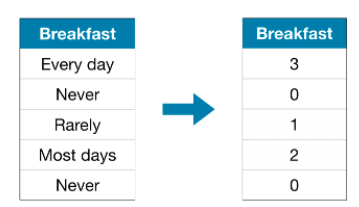

In [21]:
# 데이터셋 각 열에대해 임의의 정수로 N개 열 생성
MJTCP = 32292 # Michael Jordan total career points

def assign_rnd_integer(dataset, number_of_times = 5, seed = MJTCP):
    new_dataset = pd.DataFrame()
    np.random.seed(seed)
    for c in dataset.columns:
        for i in range(number_of_times):
            col_name = c+"_"+str(i)
            unique_vals = dataset[c].unique()
            labels = np.array(list(range(len(unique_vals))))
            np.random.shuffle(labels)
            mapping = pd.DataFrame({c: unique_vals, col_name: labels})
            new_dataset[col_name] = (dataset[[c]]
                                     .merge(mapping, on = c, how = 'left')[col_name]
                                    ).values
        return new_dataset


In [22]:
new_train, new_test = transform_dataset(
    train[col4train], test[col4train],
    assign_rnd_integer, {"number_of_times":5}
)

print(new_train.shape, new_test.shape)
new_train.head()

(32769, 5) (58921, 5)


,RESOURCE_0,RESOURCE_1,RESOURCE_2,RESOURCE_3,RESOURCE_4
0,4389,3561,5237,5701,3584
1,4111,6450,7308,5447,6616
2,4009,2880,2476,1732,6819
3,3402,4180,1831,1607,2508
4,4312,5342,5151,2891,174


In [23]:
validate_model(
    model = get_model(),
    data = [new_train.values, y]
)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,5.473461,0.392759,4.908185,5.355928,5.410896,5.814665,5.877631
score_time,5.0,0.422561,0.010704,0.412766,0.416764,0.417759,0.425767,0.439748
test_score,5.0,0.610658,0.017450,0.590383,0.596250,0.613796,0.619651,0.633212
train_score,5.0,0.926587,0.001401,0.925228,0.925396,0.926369,0.927378,0.928564


In [24]:
new_train, new_test = transform_dataset(
    train[col4train], test[col4train],
    assign_rnd_integer, {"number_of_times":1}
)

print(new_train.shape, new_test.shape)

validate_model(
    model = get_model(),
    data = [new_train.values, y]
)

(32769, 1) (58921, 1)


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,5.389711,0.406472,4.745280,5.398907,5.432888,5.500847,5.870634
score_time,5.0,0.499914,0.075553,0.426755,0.434750,0.479728,0.567675,0.590663
test_score,5.0,0.581922,0.013660,0.565906,0.570731,0.584905,0.588453,0.599614
train_score,5.0,0.926587,0.001401,0.925228,0.925396,0.926369,0.927378,0.928564


### One-hot encoding
단어를 벡터로 인코딩

각 값에 대해 존재/부재를 나타내는 새로운 열을 만든다.

범주형 변수에서도 내재 순위가 없는 명목 변수에서 수행

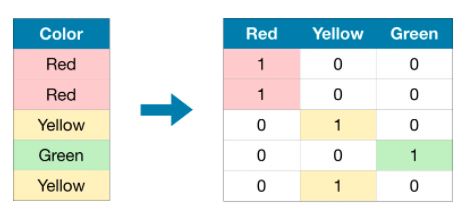

In [11]:
from sklearn.preprocessing import OneHotEncoder

def one_hot(dataset):
    ohe = OneHotEncoder(sparse=True, dtype=np.float32, handle_unknown='ignore')
    return ohe.fit_transform(dataset.values)

In [12]:
new_train, new_test = transform_dataset(
    train[col4train], test[col4train], one_hot)

print(new_train.shape, new_test.shape)

(32769, 16961) (58921, 16961)


In [13]:
'''
#Warning!!! Long run, better skip it.
validate_model(
    model = get_model(), 
    data = [new_train, y]
)
'''

'\n#Warning!!! Long run, better skip it.\nvalidate_model(\n    model = get_model(), \n    data = [new_train, y]\n)\n'

### SVD Encoding
특이값 분해(Singlar Value Decomposition, SVD)

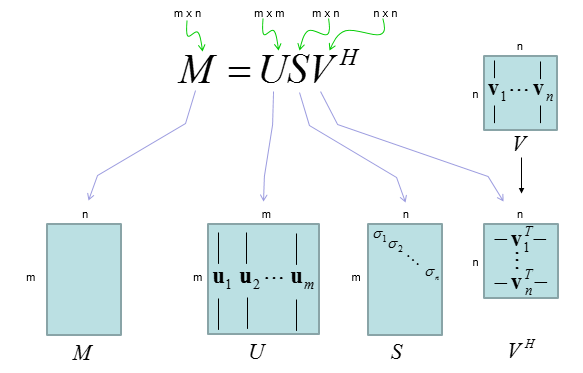

행렬을 세 가지 구성 요소로 분해하는 기술   


    M : m x n 행렬
    U : m x m 직교행렬
    S : m x n 대각행렬
    V : n x n 직교행렬
* 직교행렬 : 전치행렬과 역행렬이 같은 행렬
* 대각행렬 : 대각선 성분이 아닌 모든 성분이 0인 행렬

In [14]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def extract_col_interaction(dataset, col1, col2, tfidf = True):
    data = dataset.groupby([col1])[col2].agg(lambda x: " ".join(list([str(y) for y in x])))
    if tfidf:
        vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(" "))
    else:
        vectorizer = CountVectorizer(tokenizer=lambda x: x.split(" "))
    
    data_X = vectorizer.fit_transform(data)
    dim_red = TruncatedSVD(n_components=1, random_state = 5115)
    data_X = dim_red.fit_transform(data_X)
    
    result = pd.DataFrame()
    result[col1] = data.index.values
    result[col1+"_{}_svd".format(col2)] = data_X.ravel()
    return result

import itertools
def get_col_interactions_svd(dataset, tfidf = True):
    new_dataset = pd.DataFrame()
    for col1,col2 in itertools.permutations(dataset.columns, 2):
        data = extract_col_interaction(dataset, col1,col2, tfidf)
        col_name = [x for x in data.columns if "svd" in x][0]
        new_dataset[col_name] = dataset[[col1]].merge(data, on = col1, how = 'left')[col_name]
    return new_dataset

In [15]:
new_train, new_test = transform_dataset(
    train[col4train], test[col4train], 
    get_col_interactions_svd
)

print(new_train.shape, new_test.shape)
new_train.head(5)

(32769, 72) (58921, 72)


,RESOURCE_MGR_ID_svd,RESOURCE_ROLE_ROLLUP_1_svd,RESOURCE_ROLE_ROLLUP_2_svd,RESOURCE_ROLE_DEPTNAME_svd,RESOURCE_ROLE_TITLE_svd,RESOURCE_ROLE_FAMILY_DESC_svd,RESOURCE_ROLE_FAMILY_svd,RESOURCE_ROLE_CODE_svd,MGR_ID_RESOURCE_svd,MGR_ID_ROLE_ROLLUP_1_svd,...,ROLE_FAMILY_ROLE_FAMILY_DESC_svd,ROLE_FAMILY_ROLE_CODE_svd,ROLE_CODE_RESOURCE_svd,ROLE_CODE_MGR_ID_svd,ROLE_CODE_ROLE_ROLLUP_1_svd,ROLE_CODE_ROLE_ROLLUP_2_svd,ROLE_CODE_ROLE_DEPTNAME_svd,ROLE_CODE_ROLE_TITLE_svd,ROLE_CODE_ROLE_FAMILY_DESC_svd,ROLE_CODE_ROLE_FAMILY_svd
0,0.015059,0.999236,0.869578,0.008674,0.713359,0.695000,0.846882,0.713359,0.034007,9.999880e-01,...,0.790561,0.018801,0.518124,0.000056,0.988656,0.933793,0.082077,-0.027455,0.940899,-0.003581
1,0.034197,0.982219,0.952530,0.082501,0.196720,0.180704,0.223276,0.196720,0.174024,9.999880e-01,...,0.001405,0.059157,0.483528,0.000877,0.996758,0.726202,0.038020,0.036341,-0.000341,-0.000446
2,0.000674,0.001712,0.006027,0.261880,0.004702,0.001021,0.010063,0.004702,0.006119,5.562812e-09,...,0.016452,0.003909,0.093150,-0.000294,0.006333,0.010736,0.529856,0.033858,-0.001061,0.000406
3,0.028655,0.999236,0.934787,0.012435,0.663811,0.083169,0.994862,0.663811,0.089637,9.999880e-01,...,0.790561,0.018801,0.578121,0.000021,0.996215,0.955166,0.079606,0.130342,0.952335,-0.003581
4,0.000827,0.482659,0.111446,0.114995,0.052313,0.010280,0.064558,0.052313,0.009358,4.516656e-05,...,0.011422,0.117977,0.053252,-0.000292,0.006631,0.010132,0.506337,0.026010,0.000280,-0.000696


In [16]:
validate_model(
    model = get_model(), 
    data = [new_train.values, y]
)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,15.534099,1.119089,14.938439,15.001404,15.011400,15.190296,17.528955
score_time,5.0,0.453740,0.068046,0.413763,0.418760,0.427755,0.433750,0.574671
test_score,5.0,0.860253,0.008845,0.849835,0.853529,0.861691,0.863995,0.872215
train_score,5.0,0.999975,0.000003,0.999970,0.999975,0.999976,0.999976,0.999976


### Frequency encoding
빈도수에 따라 범주형 특징 인코딩

범주형 값이 균형을 이루는 경우 쓸 수 없다

In [17]:
def get_freq_encoding(dataset):
    new_dataset = pd.DataFrame()
    for c in dataset.columns:
        data = dataset.groupby([c]).size().reset_index()
        new_dataset[c+"_freq"] = dataset[[c]].merge(data, on = c, how = 'left')[0]
    return new_dataset

In [18]:
new_train, new_test = transform_dataset(
    train[col4train], test[col4train], 
    get_freq_encoding
)

print(new_train.shape, new_test.shape)
new_train.head(5)

(32769, 9) (58921, 9)


,RESOURCE_freq,MGR_ID_freq,ROLE_ROLLUP_1_freq,ROLE_ROLLUP_2_freq,ROLE_DEPTNAME_freq,ROLE_TITLE_freq,ROLE_FAMILY_DESC_freq,ROLE_FAMILY_freq,ROLE_CODE_freq
0,7,145,59065,12155,180,9569,17996,28861,9569
1,93,34,59065,10920,406,213,29,3506,213
2,8,7,518,518,1645,3838,92,7768,3838
3,2,153,59065,10920,494,12082,3244,28861,12082
4,28,18,815,396,143,187,41,945,187


In [19]:
validate_model(
    model = get_model(), 
    data = [new_train.values, y]
)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,6.472091,0.082142,6.416322,6.420321,6.436313,6.474291,6.613209
score_time,5.0,0.376584,0.059225,0.308822,0.314821,0.415761,0.419759,0.423757
test_score,5.0,0.822072,0.011879,0.806360,0.817696,0.819074,0.830230,0.837001
train_score,5.0,0.999881,0.000022,0.999843,0.999881,0.999884,0.999895,0.999899


### 변환값 결합

In [25]:
new_train1, new_test1 = transform_dataset(
    train[col4train], test[col4train], get_freq_encoding
)
new_train2, new_test2 = transform_dataset(
    train[col4train], test[col4train], get_col_interactions_svd
)
new_train3, new_test3 = transform_dataset(
    train[col4train], test[col4train], 
    assign_rnd_integer, {"number_of_times":10}
)

new_train = pd.concat([new_train1, new_train2, new_train3], axis = 1)
new_test = pd.concat([new_test1, new_test2, new_test3], axis = 1)
print(new_train.shape, new_test.shape)

(32769, 91) (58921, 91)


In [26]:
validate_model(
    model = get_model(), 
    data = [new_train.values, y]
)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,19.858224,1.057662,18.479413,19.346912,19.764673,20.440305,21.259818
score_time,5.0,0.485318,0.055230,0.425756,0.446744,0.466730,0.541690,0.545669
test_score,5.0,0.872513,0.009732,0.861087,0.866085,0.870576,0.880487,0.884329
train_score,5.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
model = get_model()
model.fit(new_train.values, y)
predictions = model.predict_proba(new_test)[:,1]

submit = pd.DataFrame()
submit["Id"] = test["id"]
submit["ACTION"] = predictions

submit.to_csv("data/submission2.csv", index = False)

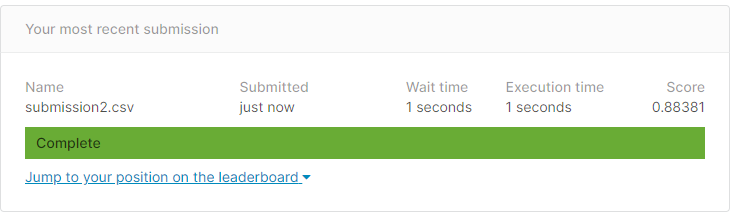